# 数值解
## 初始化
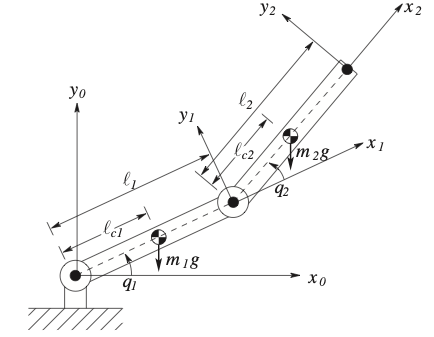

In [1]:
from roboticstoolbox import DHRobot, RevoluteDH, ERobot, ELink, ETS
from math import pi, sin, cos
import numpy as np
np.set_printoptions(linewidth=100, suppress=True)

# link 1
m1 = 1
l1 = 1
lc1 = 0.5

# link 2
m2 = 1
l2 = 1
lc2 = 0.5

# joint configurations
q1 = [0, 0]        # o-o- arm horizontal
q2 = [0, pi/2]    # o-o| upper arm horizontal, lower arm vertical
q3 = [pi/2, 0]    # o|o| arm vertical
q4 = [pi/2, -pi/2] # o|o- upper arm upward, lower arm horizontal
qq = [q1, q2, q3, q4]
z = [0, 0]

# global parameters
g = 9.81

## DH参数

In [2]:
L1 = RevoluteDH(a=l1, m=m1, r=[-lc1, 0, 0])
L2 = RevoluteDH(a=l2, m=m2, r=[-lc2, 0, 0])
robot = DHRobot([L1, L2], gravity=[0, g, 0])
print(robot)
print(robot.dynamics())


DHRobot: , 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ │  ⍺ⱼ  │
├─────┼────┼────┼──────┤
│  q1 │  0 │  1 │ 0.0° │
│  q2 │  0 │  1 │ 0.0° │
└─────┴────┴────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬────┬──────────────┬────────────────────────┬────┬────┬────────┬────┐
│   j   │ m  │      r       │           I            │ Jm │ B  │   Tc   │ G  │
├───────┼────┼──────────────┼────────────────────────┼────┼────┼────────┼────┤
│ link1 │  1 │ -0.5,  0,  0 │  0,  0,  0,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link2 │  1 │ -0.5,  0,  0 │  0,  0,  0,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
└───────┴────┴──────────────┴────────────────────────┴────┴────┴────────┴────┘

None


In [4]:
# 创建连杆
# 假设所有关节都是旋转关节 (Revolute)
"""
L1 = DHLink(a=0, alpha=0, d=0, theta=0)
L2 = DHLink(a=1, alpha=0, d=0, theta=0)
L3 = DHLink(a=1, alpha=0, d=0, theta=0)
yk_robot = DHRobot(links=[L1, L2, L3], name='Planar3LinkRobot')
print(yk_robot)
"""

"\nL1 = DHLink(a=0, alpha=0, d=0, theta=0)\nL2 = DHLink(a=1, alpha=0, d=0, theta=0)\nL3 = DHLink(a=1, alpha=0, d=0, theta=0)\nyk_robot = DHRobot(links=[L1, L2, L3], name='Planar3LinkRobot')\nprint(yk_robot)\n"

## 运动学

In [6]:
T = robot.fkine([0.1, 0.2])
print(T)

   0.9553   -0.2955    0         1.95      
   0.2955    0.9553    0         0.3954    
   0         0         1         0         
   0         0         0         1         



In [8]:
sol = robot.ikine_LM(T)
print(sol)

IKSolution: q=[0.1, 0.2], success=True, iterations=7, searches=1, residual=4.81e-08


## 差分运动学

In [9]:
J = robot.jacob0([0.1,0.2])
J

array([[-0.39535362, -0.29552021],
       [ 1.95034065,  0.95533649],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 1.        ,  1.        ]])

## 动力学

In [ ]:
import roboticstoolbox as rtb
import sympy as sp

# 定义符号变量
theta1, theta2 = sp.symbols('theta1 theta2')      # 关节角
dtheta1, dtheta2 = sp.symbols('dtheta1 dtheta2')  # 关节角速度
ddtheta1, ddtheta2 = sp.symbols('ddtheta1 ddtheta2')  # 关节角加速度
m1, m2 = sp.symbols('m1 m2')  # 连杆质量
l1, l2 = sp.symbols('l1 l2')  # 连杆长度
lc1, lc2 = sp.symbols('lc1 lc2')  # 连杆质心位置
I1, I2 = sp.symbols('I1 I2')  # 连杆惯性
g = sp.symbols('g')  # 重力加速度

# 定义连杆参数
dh_params = [
    [theta1, 0, l1, 0],  # 第一根连杆
    [theta2, 0, l2, 0]   # 第二根连杆
]

# 创建平面RR机器人模型
robot = rtb.DHRobot([
    rtb.RevoluteDH(theta1, 0, l1, 0),
    rtb.RevoluteDH(theta2, 0, l2, 0)
], name='Planar RR')

# 定义质心位置向量
r1 = sp.Matrix([lc1 * sp.cos(theta1), lc1 * sp.sin(theta1)])
r2 = sp.Matrix([l1 * sp.cos(theta1) + lc2 * sp.cos(theta1 + theta2),
                l1 * sp.sin(theta1) + lc2 * sp.sin(theta1 + theta2)])

# 定义速度向量
v1 = sp.diff(r1, theta1) * dtheta1
v2 = sp.diff(r2, theta1) * dtheta1 + sp.diff(r2, theta2) * dtheta2

# 计算动能和势能
T1 = (1/2) * m1 * v1.dot(v1) + (1/2) * I1 * dtheta1**2
T2 = (1/2) * m2 * v2.dot(v2) + (1/2) * I2 * (dtheta1 + dtheta2)**2
T = T1 + T2

V1 = m1 * g * lc1 * sp.sin(theta1)
V2 = m2 * g * (l1 * sp.sin(theta1) + lc2 * sp.sin(theta1 + theta2))
V = V1 + V2

# 拉格朗日函数
L = T - V

# 推导拉格朗日方程
dL_dtheta1 = sp.diff(L, theta1)
dL_dtheta2 = sp.diff(L, theta2)
dL_ddtheta1 = sp.diff(L, dtheta1)
dL_ddtheta2 = sp.diff(L, dtheta2)

ddt_dL_ddtheta1 = sp.diff(dL_ddtheta1, theta1) * dtheta1 + sp.diff(dL_ddtheta1, theta2) * dtheta2 + sp.diff(dL_ddtheta1, dtheta1) * ddtheta1 + sp.diff(dL_ddtheta1, dtheta2) * ddtheta2
ddt_dL_ddtheta2 = sp.diff(dL_ddtheta2, theta1) * dtheta1 + sp.diff(dL_ddtheta2, theta2) * dtheta2 + sp.diff(dL_ddtheta2, dtheta1) * ddtheta1 + sp.diff(dL_ddtheta2, dtheta2) * ddtheta2

EOM1 = sp.simplify(ddt_dL_ddtheta1 - dL_dtheta1)
EOM2 = sp.simplify(ddt_dL_ddtheta2 - dL_dtheta2)

# 打印推导的运动方程
sp.pprint(EOM1)
sp.pprint(EOM2)


In [ ]:
sp.pprint(EOM2)

In [12]:
from sympy import symbols, cos, sin, simplify
from sympy.physics.mechanics import dynamicsymbols
from sympybotics import RobotDef
# , RigidBody
# from sympybotics import simplify_kinematic_equations

# 定义动力学符号
q1, q2 = symbols('q1 q2')

# 定义符号
l1, l2 = symbols('l1 l2')
d1, d2 = symbols('d1 d2')
r, alpha, beta = symbols('r alpha beta')

# 定义机器人参数
robot_def = RobotDef(
    '2R',
    [(q1, 0, l1, 0), (q2, 0, l2, 0)],
    dh_convention='mdh')

# 构建机器人模型
# rb = RigidBody('Link1', robot_def.dyn.base, robot_def.dyn.base_frame, 0, robot_def)
rb = robot

# 计算正运动学
T01 = rb.T[(q1,)]
T12 = rb.T[(q2,)]

# 合成正运动学矩阵
T02 = simplify(T01 * T12)

# 提取正运动学方程中的变量
T02 = T02.subs(robot_def.dyn.q[0], q1)
T02 = T02.subs(robot_def.dyn.q[1], q2)

# 提取正运动学方程中的变量
T02 = T02.subs(robot_def.dyn.frames[1].d, d1)
T02 = T02.subs(robot_def.dyn.frames[2].d, d2)

# 提取正运动学方程中的变量
T02 = T02.subs(robot_def.dyn.frames[1].r, r)
T02 = T02.subs(robot_def.dyn.frames[1].alpha, alpha)
T02 = T02.subs(robot_def.dyn.frames[1].beta, beta)

# 简化正运动学方程
T02 = simplify(T02)

print("正运动学解为：", T02)


AttributeError: 'DHRobot' object has no attribute 'T'

In [17]:
rb.fkine([q1,q2])

  -1.0*sin(q1)*sin(q2) + cos(q1)*cos(q2) -1.0*sin(q1)*cos(q2) - 1.0*sin(q2)*cos(q1) 0            l_1*cos(q1) - 1.0*l_2*sin(q1)*sin(q2) + l_2*cos(q1)*cos(q2)  
  sin(q1)*cos(q2) + 1.0*sin(q2)*cos(q1) -1.0*sin(q1)*sin(q2) + 1.0*cos(q1)*cos(q2) 0            l_1*sin(q1) + l_2*sin(q1)*cos(q2) + 1.0*l_2*sin(q2)*cos(q1)  
  0            0            1.00000000000000 0             
  0            0            0            1             


# 符号解
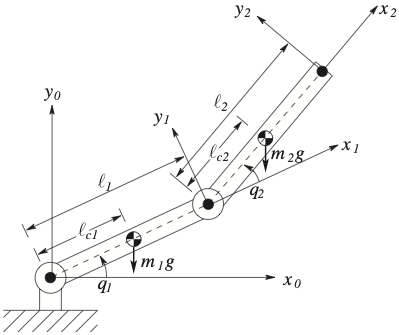
## 初始化

In [2]:
from roboticstoolbox import DHRobot, RevoluteDH, ERobot, ELink, ETS
from math import pi, sin, cos
import numpy as np
from spatialmath.base import symbol

# link 1
m1 = symbol('m_1')
l1 = symbol('l_1')
lc1 = symbol('l_c_1')

# link 2
m2 = symbol('m_2')
l2 = symbol('l_2')
lc2 = symbol('l_c_2')

g = symbol('g')

L1 = RevoluteDH(a=l1, m=m1, r=[-lc1, 0, 0])
L2 = RevoluteDH(a=l2, m=m2, r=[-lc2, 0, 0])
robot = DHRobot([L1, L2], gravity=[0, g, 0], symbolic=True)

print(robot)
print(robot.dynamics())

DHRobot: , 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ l_1 │ 0.0° │
│  q2 │  0 │ l_2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬─────┬──────────────┬────────────────────────┬────┬────┬────────┬────┐
│   j   │  m  │      r       │           I            │ Jm │ B  │   Tc   │ G  │
├───────┼─────┼──────────────┼────────────────────────┼────┼────┼────────┼────┤
│ link1 │ m_1 │ -l_c_1, 0, 0 │  0,  0,  0,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link2 │ m_2 │ -l_c_2, 0, 0 │  0,  0,  0,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
└───────┴─────┴──────────────┴────────────────────────┴────┴────┴────────┴────┘

None


## 运动学

In [3]:
# 正运动学符号解
import spatialmath.base as base
from sympy import Matrix

q = base.sym.symbol("q_:2") # q = (q_1, q_2)
T = robot.fkine(q)
Ts = T.simplify()
M = Matrix(Ts.A)
M

Matrix([
[1.0*cos(q_0 + q_1), -1.0*sin(q_0 + q_1),   0, 1.0*l_1*cos(q_0) + 1.0*l_2*cos(q_0 + q_1)],
[1.0*sin(q_0 + q_1),  1.0*cos(q_0 + q_1),   0, 1.0*l_1*sin(q_0) + 1.0*l_2*sin(q_0 + q_1)],
[                 0,                   0, 1.0,                                         0],
[                 0,                   0,   0,                                         1]])

In [52]:
# 符号解转为python格式
from sympy import ccode, pycode, octave_code
print(pycode(M[0,0]))

1.0*math.cos(q_0 + q_1)


In [18]:
# 符号解转为数值解
from sympy import lambdify
T_func = lambdify(q, M, modules='numpy')
T_func(0.5*np.pi, 0)

array([[6.123233995736766e-17, -1.0, 0,
        6.12323399573677e-17*l_1 + 6.12323399573677e-17*l_2],
       [1.0, 6.123233995736766e-17, 0, 1.0*l_1 + 1.0*l_2],
       [0, 0, 1.0, 0],
       [0, 0, 0, 1]], dtype=object)

In [4]:
# 差分运动学
from sympy import trigsimp, simplify
J = robot.jacob0(q)
M = Matrix(simplify(J))
M

Matrix([
[-1.0*l_1*sin(q_0) - 1.0*l_2*sin(q_0 + q_1), -1.0*l_2*sin(q_0 + q_1)],
[ 1.0*l_1*cos(q_0) + 1.0*l_2*cos(q_0 + q_1),  1.0*l_2*cos(q_0 + q_1)],
[                                         0,                       0],
[                                         0,                       0],
[                                         0,                       0],
[                                       1.0,                     1.0]])

## 动力学
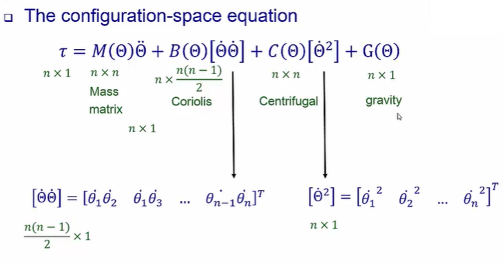

In [5]:
q = symbol('q_:2')
qd = symbol('qd_:2')
qdd = symbol('qdd_:2')
tau = robot.rne_python(q, qd, qdd)
tau

array([1.0*l_1*m_2*(-l_2*(1.0*qd_0 + 1.0*qd_1)**2 + l_c_2*(1.0*qd_0 + 1.0*qd_1)**2 + (-g*sin(q_0) - 1.0*l_1*qd_0**2)*cos(q_1) + (-1.0*g*cos(q_0) + 1.0*l_1*qdd_0)*sin(q_1))*sin(q_1) + 1.0*l_1*m_2*(l_2*(1.0*qdd_0 + 1.0*qdd_1) - l_c_2*(1.0*qdd_0 + 1.0*qdd_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1) + 1.0*(-1.0*g*cos(q_0) + 1.0*l_1*qdd_0)*cos(q_1))*cos(q_1) + 1.0*m_1*(l_1 - l_c_1)*(-1.0*g*cos(q_0) + 1.0*l_1*qdd_0 - 1.0*l_c_1*qdd_0) + 1.0*m_2*(l_2 - l_c_2)*(l_2*(1.0*qdd_0 + 1.0*qdd_1) - l_c_2*(1.0*qdd_0 + 1.0*qdd_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1) + 1.0*(-1.0*g*cos(q_0) + 1.0*l_1*qdd_0)*cos(q_1)),
       1.0*m_2*(l_2 - l_c_2)*(l_2*(1.0*qdd_0 + 1.0*qdd_1) - l_c_2*(1.0*qdd_0 + 1.0*qdd_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1) + 1.0*(-1.0*g*cos(q_0) + 1.0*l_1*qdd_0)*cos(q_1))],
      dtype=object)

In [6]:
%time M = Matrix(simplify(tau))
M

Wall time: 9.89 s


Matrix([
[1.0*l_1*m_2*(-g*cos(q_0 + q_1) + l_1*qd_0**2*sin(q_1) + l_1*qdd_0*cos(q_1) + l_2*qdd_0 + l_2*qdd_1 - l_c_2*qdd_0 - l_c_2*qdd_1)*cos(q_1) - 1.0*l_1*m_2*(1.0*g*sin(q_0 + q_1) + 1.0*l_1*qd_0**2*cos(q_1) - 1.0*l_1*qdd_0*sin(q_1) + 1.0*l_2*qd_0**2 + 2.0*l_2*qd_0*qd_1 + 1.0*l_2*qd_1**2 - 1.0*l_c_2*qd_0**2 - 2.0*l_c_2*qd_0*qd_1 - 1.0*l_c_2*qd_1**2)*sin(q_1) - 1.0*m_1*(l_1 - l_c_1)*(g*cos(q_0) - l_1*qdd_0 + l_c_1*qdd_0) + 1.0*m_2*(l_2 - l_c_2)*(-g*cos(q_0 + q_1) + l_1*qd_0**2*sin(q_1) + l_1*qdd_0*cos(q_1) + l_2*qdd_0 + l_2*qdd_1 - l_c_2*qdd_0 - l_c_2*qdd_1)],
[                                                                                                                                                                                                                                                                                                                                                                                                                                  1.0*m_2*(l_2 

In [7]:
tau_0 = tau[0].expand()
tau_1 = tau[1].expand()

### mass matrix
nxn

In [8]:
# mass matrix M00
m = tau_0.coeff(qdd[0]).args
simplify(m)

(1.0*l_1**2*m_1, 1.0*l_c_1**2*m_1, 1.0*l_2**2*m_2, 1.0*l_c_2**2*m_2, 1.0*l_1**2*m_2*cos(q_1)**2, 1.0*l_1**2*m_2*sin(q_1)**2, -2.0*l_1*l_c_1*m_1, -2.0*l_2*l_c_2*m_2, 2.0*l_1*l_2*m_2*cos(q_1), -2.0*l_1*l_c_2*m_2*cos(q_1))

In [9]:
# mass matrix M01
m = tau_0.coeff(qdd[1]).args
simplify(m)

(1.0*l_2**2*m_2, 1.0*l_c_2**2*m_2, -2.0*l_2*l_c_2*m_2, 1.0*l_1*l_2*m_2*cos(q_1), -1.0*l_1*l_c_2*m_2*cos(q_1))

In [10]:
# mass matrix M10
m = tau_1.coeff(qdd[0]).args
simplify(m)

(1.0*l_2**2*m_2, 1.0*l_c_2**2*m_2, -2.0*l_2*l_c_2*m_2, 1.0*l_1*l_2*m_2*cos(q_1), -1.0*l_1*l_c_2*m_2*cos(q_1))

In [11]:
# mass matrix M11
m = tau_1.coeff(qdd[1]).args
simplify(m)

(1.0*l_2**2*m_2, 1.0*l_c_2**2*m_2, -2.0*l_2*l_c_2*m_2)

### codiolis

In [19]:
m = tau_0.coeff(qd[0]).coeff(qd[1]).args
simplify(m)

(2.0*l_1*l_c_2*m_2*sin(q_1), -2.0*l_1*l_2*m_2*sin(q_1))

In [13]:
m = tau_1.coeff(qd[0]).coeff(qd[1]).args
simplify(m)

()

### centrifugal

In [15]:
m = tau_0.coeff(qd[0]).coeff(qd[0]).args
simplify(m)

()

In [16]:
m = tau_0.coeff(qd[1]).coeff(qd[1]).args
simplify(m)

()

In [17]:
m = tau_1.coeff(qd[0]).coeff(qd[0]).args
simplify(m)

()

In [18]:
m = tau_1.coeff(qd[1]).coeff(qd[1]).args
simplify(m)

()

In [31]:
import sympy as sp
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath.base import symbolic as sym

# 定义符号
theta1, theta2, l1, l2 = sp.symbols('theta1 theta2 l1 l2')
theta1_dot, theta2_dot = sp.symbols('theta1_dot theta2_dot')
theta1_ddot, theta2_ddot = sp.symbols('theta1_ddot theta2_ddot')
g, m1, m2, I1, I2 = sp.symbols('g m1 m2 I1 I2')

# 定义机器人
link1 = RevoluteDH(a=l1, alpha=0, d=0, theta=theta1)
link2 = RevoluteDH(a=l2, alpha=0, d=0, theta=theta2)
robot = DHRobot([link1, link2], name='2-Link Planar Robot')

# 计算正运动学
T = robot.fkine([theta1, theta2])

# 动能 T 和势能 V 的定义
T = 0.5 * m1 * (l1**2 * theta1_dot**2) + \
    0.5 * m2 * ((l1 * theta1_dot)**2 + (l2 * theta2_dot)**2 + 2 * l1 * l2 * theta1_dot * theta2_dot * sp.cos(theta2)) + \
    0.5 * I1 * theta1_dot**2 + 0.5 * I2 * theta2_dot**2

V = m1 * g * l1 * sp.cos(theta1) + m2 * g * (l1 * sp.cos(theta1) + l2 * sp.cos(theta1 + theta2))

# 拉格朗日 L
L = T - V

# 拉格朗日方程
L_eq1 = sp.diff(sp.diff(L, theta1_dot), 't') - sp.diff(L, theta1)
L_eq2 = sp.diff(sp.diff(L, theta2_dot), 't') - sp.diff(L, theta2)

# 替换导数
L_eq1 = L_eq1.subs({sp.diff(theta1_dot): theta1_ddot, sp.diff(theta2_dot): theta2_ddot})
L_eq2 = L_eq2.subs({sp.diff(theta1_dot): theta1_ddot, sp.diff(theta2_dot): theta2_ddot})

# 解方程
sol = sp.solve([L_eq1, L_eq2], (theta1_ddot, theta2_ddot))

print("Theta1_ddot:")
print(sol[theta1_ddot])
print("\nTheta2_ddot:")
print(sol[theta2_ddot])


TypeError: __init__() got multiple values for keyword argument 'theta'

In [39]:
signif_terms = [t for t in tau_0.args if abs(t.args[0]) > 1e-6]
signif_terms

[1.0*l_1**2*m_1*qdd_0,
 1.0*l_c_1**2*m_1*qdd_0,
 1.0*l_2**2*m_2*qdd_0,
 1.0*l_c_2**2*m_2*qdd_0,
 1.0*l_2**2*m_2*qdd_1,
 1.0*l_c_2**2*m_2*qdd_1,
 1.0*g*l_c_1*m_1*cos(q_0),
 1.0*l_1**2*m_2*qdd_0*cos(q_1)**2,
 1.0*l_1**2*m_2*qdd_0*sin(q_1)**2,
 -1.0*g*l_1*m_1*cos(q_0),
 -2.0*l_1*l_c_1*m_1*qdd_0,
 -2.0*l_2*l_c_2*m_2*qdd_0,
 -2.0*l_2*l_c_2*m_2*qdd_1,
 1.0*g*l_2*m_2*sin(q_0)*sin(q_1),
 1.0*g*l_c_2*m_2*cos(q_0)*cos(q_1),
 1.0*l_1*l_2*m_2*qdd_1*cos(q_1),
 1.0*l_1*l_c_2*m_2*qd_1**2*sin(q_1),
 2.0*l_1*l_2*m_2*qdd_0*cos(q_1),
 -1.0*g*l_1*m_2*cos(q_0)*cos(q_1)**2,
 -1.0*g*l_1*m_2*sin(q_1)**2*cos(q_0),
 -1.0*g*l_2*m_2*cos(q_0)*cos(q_1),
 -1.0*g*l_c_2*m_2*sin(q_0)*sin(q_1),
 -1.0*l_1*l_2*m_2*qd_1**2*sin(q_1),
 -1.0*l_1*l_c_2*m_2*qdd_1*cos(q_1),
 -2.0*l_1*l_c_2*m_2*qdd_0*cos(q_1),
 2.0*l_1*l_c_2*m_2*qd_0*qd_1*sin(q_1),
 -2.0*l_1*l_2*m_2*qd_0*qd_1*sin(q_1)]

In [30]:
print(pycode(tau_0))

NameError: name 'pycode' is not defined